In [8217]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage as ndi
from scipy.stats import mode
from sklearn.cluster import DBSCAN

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

In [8218]:
# https://github.com/AndraRaco/Graham-s-scan/tree/master

from __future__ import annotations

from collections import deque
from enum import Enum
from math import atan2, degrees
from sys import maxsize


def graham_scan(points: list[list[int, int]]) -> list[list[int, int]]:
    """Pure implementation of graham scan algorithm in Python

    :param points: The unique points on coordinates.
    :return: The points on convex hell.

    Examples:
    >>> graham_scan([(9, 6), (3, 1), (0, 0), (5, 5), (5, 2), (7, 0), (3, 3), (1, 4)])
    [(0, 0), (7, 0), (9, 6), (5, 5), (1, 4)]

    >>> graham_scan([(0, 0), (1, 0), (1, 1), (0, 1)])
    [(0, 0), (1, 0), (1, 1), (0, 1)]

    >>> graham_scan([(0, 0), (1, 1), (2, 2), (3, 3), (-1, 2)])
    [(0, 0), (1, 1), (2, 2), (3, 3), (-1, 2)]

    >>> graham_scan([(-100, 20), (99, 3), (1, 10000001), (5133186, -25), (-66, -4)])
    [(5133186, -25), (1, 10000001), (-100, 20), (-66, -4)]
    """

    if len(points) <= 2:
        # There is no convex hull
        raise ValueError("graham_scan: argument must contain more than 3 points.")
    if len(points) == 3:
        return points
    # find the lowest and the most left point
    minidx = 0
    miny, minx = maxsize, maxsize
    for i, point in enumerate(points):
        x = point[0]
        y = point[1]
        if y < miny:
            miny = y
            minx = x
            minidx = i
        if y == miny:
            if x < minx:
                minx = x
                minidx = i

    # remove the lowest and the most left point from points for preparing for sort
    points.pop(minidx)

    def angle_comparer(point: list[int, int], minx: int, miny: int) -> float:
        """Return the angle toward to point from (minx, miny)

        :param point: The target point
               minx: The starting point's x
               miny: The starting point's y
        :return: the angle

        Examples:
        >>> angle_comparer([1,1], 0, 0)
        45.0

        >>> angle_comparer([100,1], 10, 10)
        -5.710593137499642

        >>> angle_comparer([5,5], 2, 3)
        33.690067525979785
        """
        # sort the points accorgind to the angle from the lowest and the most left point
        x = point[0]
        y = point[1]
        angle = degrees(atan2(y - miny, x - minx))
        return angle

    sorted_points = sorted(points, key=lambda point: angle_comparer(point, minx, miny))
    # This insert actually costs complexity,
    # and you should insteadly add (minx, miny) into stack later.
    # I'm using insert just for easy understanding.
    sorted_points.insert(0, (minx, miny))

    # traversal from the lowest and the most left point in anti-clockwise direction
    # if direction gets right, the previous point is not the convex hull.
    class Direction(Enum):
        left = 1
        straight = 2
        right = 3

    def check_direction(
        starting: list[int, int], via: list[int, int], target: list[int, int]
    ) -> Direction:
        """Return the direction toward to the line from via to target from starting

        :param starting: The starting point
               via: The via point
               target: The target point
        :return: the Direction

        Examples:
        >>> check_direction([1,1], [2,2], [3,3])
        Direction.straight

        >>> check_direction([60,1], [-50,199], [30,2])
        Direction.left

        >>> check_direction([0,0], [5,5], [10,0])
        Direction.right
        """
        x0, y0 = starting
        x1, y1 = via
        x2, y2 = target
        via_angle = degrees(atan2(y1 - y0, x1 - x0))
        if via_angle < 0:
            via_angle += 360
        target_angle = degrees(atan2(y2 - y0, x2 - x0))
        if target_angle < 0:
            target_angle += 360
        # t-
        #  \ \
        #   \ v
        #    \|
        #     s
        # via_angle is always lower than target_angle, if direction is left.
        # If they are same, it means they are on a same line of convex hull.
        if target_angle > via_angle:
            return Direction.left
        if target_angle == via_angle:
            return Direction.straight
        if target_angle < via_angle:
            return Direction.right

    stack = deque()
    stack.append(sorted_points[0])
    stack.append(sorted_points[1])
    stack.append(sorted_points[2])
    # In any ways, the first 3 points line are towards left.
    # Because we sort them the angle from minx, miny.
    current_direction = Direction.left

    for i in range(3, len(sorted_points)):
        while True:
            starting = stack[-2]
            via = stack[-1]
            target = sorted_points[i]
            next_direction = check_direction(starting, via, target)

            if next_direction == Direction.left:
                current_direction = Direction.left
                break
            if next_direction == Direction.straight:
                if current_direction == Direction.left:
                    # We keep current_direction as left.
                    # Because if the straight line keeps as straight,
                    # we want to know if this straight line is towards left.
                    break
                elif current_direction == Direction.right:
                    # If the straight line is towards right,
                    # every previous points on those straigh line is not convex hull.
                    stack.pop()
            if next_direction == Direction.right:
                stack.pop()
        stack.append(sorted_points[i])
    return stack

In [8219]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage as ndi
from scipy.stats import mode
from sklearn.cluster import DBSCAN

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

In [8220]:
def angular_difference(theta1, theta2):
    # Normalize angles between 0 and pi
    theta1 = np.mod(theta1, np.pi)
    theta2 = np.mod(theta2, np.pi)
    # Compute the absolute difference in angles
    diff = np.abs(theta1 - theta2)
    # Angles are periodic, with period pi (180 degrees), so take the min with pi - diff
    return min(diff, np.pi - diff)

In [8221]:
def hough_line_intersection(line1, line2):
    # Find the intersection of two lines defined by Hough transform.
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)

    return float(x0), float(y0)  # Make sure the return values are floats

In [8222]:
def find_intersections(hough_lines, convex_hull, angular_threshold):
    angular_threshold = np.radians(angular_threshold)
    intersections = []
    # Find all the intersection points from the lines
    for i, line1 in enumerate(hough_lines):
        for line2 in hough_lines[i+1:]:
            rho1, theta1 = line1[0]
            rho1, theta2 = line2[0]
            if angular_difference(theta1, theta2) > angular_threshold:
                try:
                    x, y = hough_line_intersection(line1, line2)
                    intersections.append((x, y))
                except np.linalg.LinAlgError:  # This occurs when there's no intersection (parallel lines).
                    continue

    # Convert hull points to a suitable format for pointPolygonTest
    hull_points = convex_hull.reshape(-1, 2)

    # Filter intersections that are close to the convex hull
    near_hull_intersections = []
    for point in intersections:
        # Convert point to a tuple of floats if it isn't already
        dist = cv2.pointPolygonTest(hull_points, (point[0],point[1]), True)
        thresh = cv2.arcLength(convex_hull,True)/50

        if dist > -thresh and dist < thresh:  # Adjust the threshold as needed
            near_hull_intersections.append((int(point[0]), int(point[1])))

    return near_hull_intersections

In [8223]:
def is_circle(contour, epsilon_factor=0.02, roundness_threshold=0.71):
    approx = cv2.approxPolyDP(contour, epsilon_factor * cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0: return False
    area_of_circle = (perimeter ** 2) / (4 * 3.14159)
    roundness = area / area_of_circle
    print(roundness)
    return roundness > roundness_threshold

In [8224]:
def pad_to_square(image):
    # Calculate the difference between the height and the width
    height, width = image.shape[:2]
    delta = abs(height - width)
    top = bottom = left = right = 0

    # Pad width if the image is taller than it is wide
    if height > width:
        left = right = delta // 2
    # Pad height if the image is wider than it is tall
    elif width > height:
        top = bottom = delta // 2

    # Use the last pixel value for padding
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    
    # If the delta is odd, we need to add one more pixel of padding to one side
    if delta % 2 != 0:
        if width < height:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 0, 0, 1, cv2.BORDER_REPLICATE)
        else:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 1, 0, 0, cv2.BORDER_REPLICATE)

    return padded_image

In [8225]:
def line_intersection(p1, p2, p3, p4):
    # Unpack points
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    
    # Calculate determinants
    det1 = x1 * y2 - y1 * x2
    det2 = x3 * y4 - y3 * x4
    xnum = det1 * (x3 - x4) - (x1 - x2) * det2
    ynum = det1 * (y3 - y4) - (y1 - y2) * det2
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    # Intersection point
    x = xnum / denom
    y = ynum / denom
    return x, y

In [8226]:
# crop image to have a square image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

In [8227]:
def most_common_hue(hsv_image, center, radius):
    sat_threshold=50
    val_threshold=160

    # Create a mask for the round area
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, (255), thickness=-1)
    
    # Extract hue values within the mask
    hues = hsv_image[:,:,0][mask == 255]
    s = hsv_image[:,:,1][mask == 255]
    v = hsv_image[:,:,2][mask == 255]

    # Find the most common hue
    if(mode(s)[0] <= sat_threshold and mode(v)[0] >= val_threshold):
        print(str(mode(s)[0])+" - "+str(mode(v)[0]))
        return -1
    else: 
        return mode(hues)[0]

In [8228]:
def hue_to_color_name_and_bgr(hue):
    # Define hue ranges for common colors
    color_ranges = {
        "red": range(0, 8),  # Red has to be split due to its position on the hue wheel
        "orange": range(8, 20), 
        "yellow": range(20, 35), 
        "green": range(35, 85),
        "blue": range(85, 125),
        # "white": Not defined by hue
        "red2": range(160, 180)  # The second part of red
    }

    # Determine color name
    color_name = None
    for color, hue_range in color_ranges.items():
        if hue == -1:
            return "white",(255,255,255)
        elif hue in hue_range:
            color_name = color
            break

    # Handle the two ranges for red
    if color_name == "red2":
        color_name = "red"

    if color_name is None:
        return None, None

    # Convert hue to BGR
    hsv_color = np.uint8([[[hue, 255, 255]]])  # Hue, Saturation, Value
    bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]

    return color_name,tuple(bgr_color)

In [8229]:
# crop image to have a square image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

In [8230]:
def pad_to_square(image):
    # Calculate the difference between the height and the width
    height, width = image.shape[:2]
    delta = abs(height - width)
    top = bottom = left = right = 0

    # Pad width if the image is taller than it is wide
    if height > width:
        left = right = delta // 2
    # Pad height if the image is wider than it is tall
    elif width > height:
        top = bottom = delta // 2

    # Use the last pixel value for padding
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    
    # If the delta is odd, we need to add one more pixel of padding to one side
    if delta % 2 != 0:
        if width < height:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 0, 0, 1, cv2.BORDER_REPLICATE)
        else:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 1, 0, 0, cv2.BORDER_REPLICATE)

    return padded_image

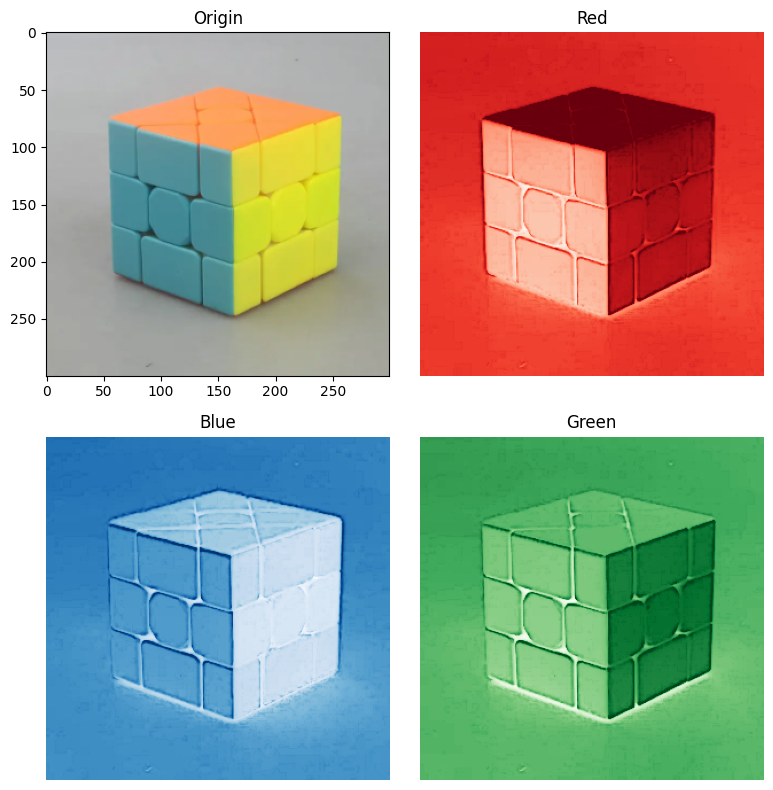

In [8231]:
original_input_image = pad_to_square(cv2.imread('Classification2/border4.jpeg'))
input_image = crop_square(original_input_image,300)

blue, green, red = cv2.split(input_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 4.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 4.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 4.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)

plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

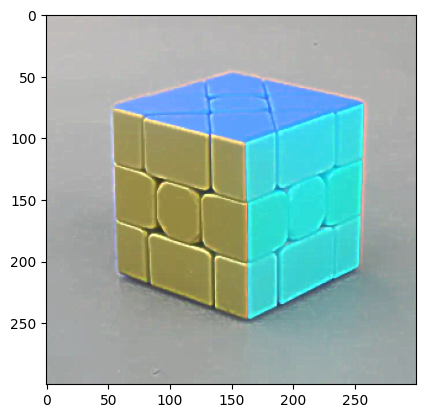

In [8232]:
# Unione dei colori
from skimage.morphology import square
from skimage import filters

high_pass_input_image = cv2.merge((blue, green, red))
HP_gray_image = cv2.cvtColor(high_pass_input_image, cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(high_pass_input_image)

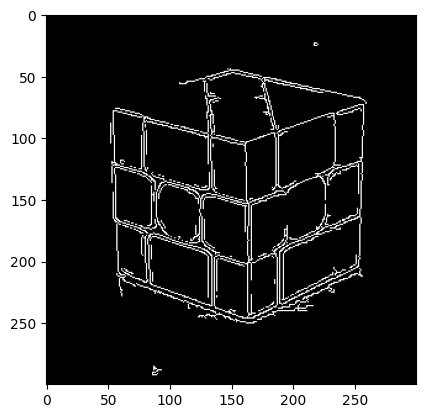

In [8233]:
iedges = cv2.Canny(HP_gray_image,30,150)

plt.imshow(iedges,cmap="gray")

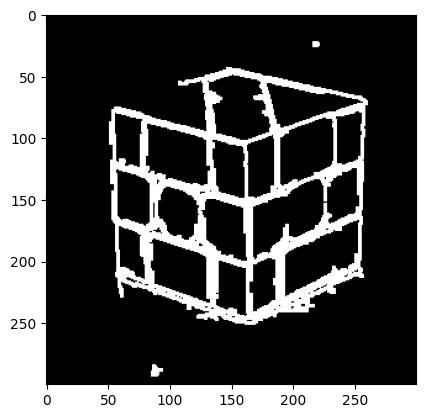

In [8234]:
# espandiamo il colore bianco, per cercare di riempire i buchi, non solo all'interno ma anche sul bordo

kernel = np.ones((3,3),np.uint8)
erosion = cv2.dilate(iedges,kernel,iterations = 1)
plt.imshow(erosion,cmap="gray")

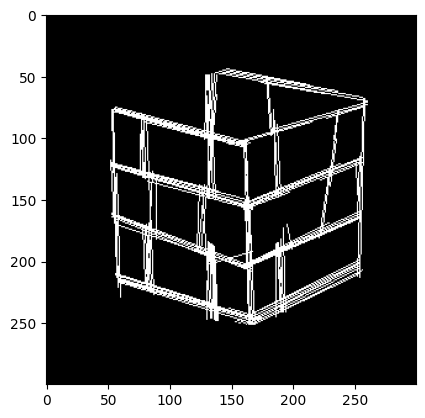

In [8235]:
# dato che le linee del bordo trovate finora sono anche piene di noise, nonostante lo smussamento, uso una funzione che data una forma, si ricava delle linee DRITTE

lines = cv2.HoughLinesP(erosion, 1, np.pi/360, threshold=50, minLineLength=20, maxLineGap=10)

# Disegna le linee sull'immagine originale per visualizzazione
image_with_lines = np.zeros_like(erosion)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), 255, 1)
plt.imshow(image_with_lines,cmap="gray")

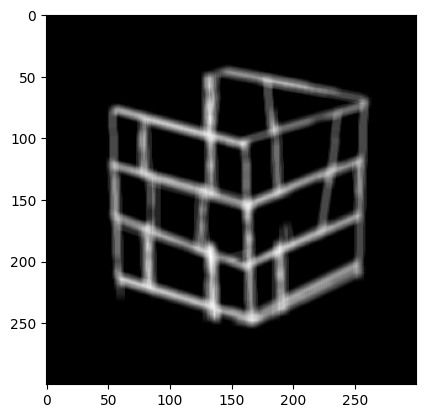

In [8236]:
mean_kernel = np.full((7, 7), 1/49)
mean = ndi.correlate(image_with_lines, mean_kernel)
plt.imshow(mean,cmap="gray")

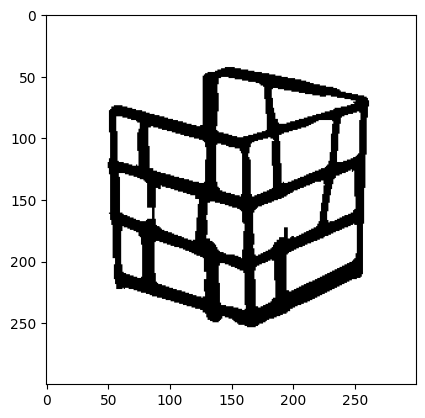

In [8237]:
# effettuiamo threshold, portando a 255 tutto ciò che non è totalmente nero (si si vede che grazie allo smussamento molti buchi vengono riempiti)
ret,thresh = cv2.threshold(mean,50,255,cv2.THRESH_BINARY)
thresh = cv2.bitwise_not(thresh)
plt.imshow(thresh,cmap="gray")

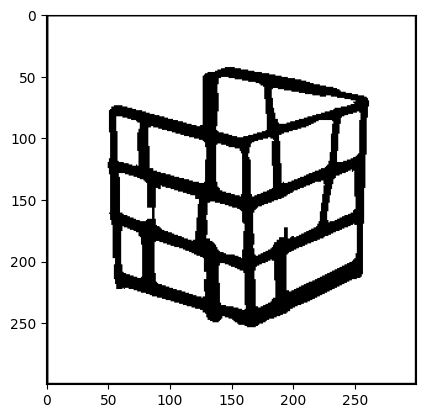

In [8238]:
# diamo per scontato che ci possono essere delle linee orizzontali, quindi del rumore nel background
# per fare in modo di rimoverlo, creiamo uno cornice nera intorno alla immagine (se non c'è noise allora non è visibile)

thickness = 2

cv2.line(thresh, (0,0), (0,300), 0, thickness)
cv2.line(thresh, (0,300), (300,300), 0, thickness)
cv2.line(thresh, (300,300), (300,0), 0, thickness)
cv2.line(thresh, (300,0), (0,0), 0, thickness)

plt.imshow(thresh,cmap="gray")

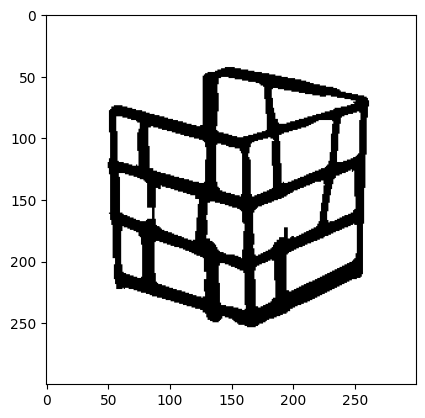

In [8239]:
# facciamo un fill per rimuovere noise nel background, partendo dalla cornice nera creata precedentemente
# proprio grazia alla cornice, partendo da un solo punto, possiamo rimepire da tutto il bordo!

cv2.floodFill(thresh, None, (0, 0), (255,255,255))

plt.imshow(thresh,cmap="gray")

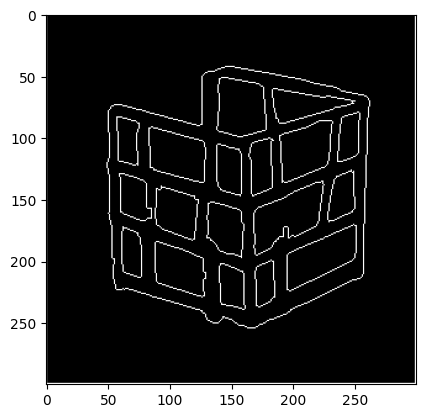

In [8240]:
# identification of the cube and other obkects from the nosie

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
borders = np.zeros_like(thresh)
edge_image = cv2.drawContours(borders, contours, -1, (255, 255, 255), 1)
plt.imshow(edge_image,cmap="gray")

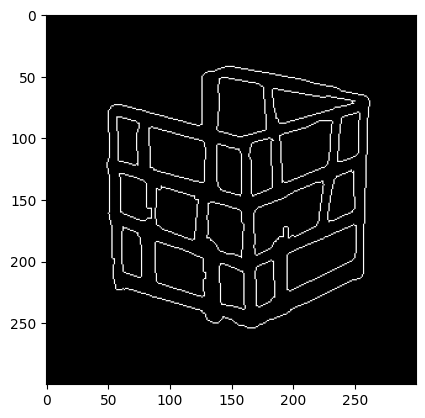

In [8241]:
# diamo per scontato che ci possono essere delle linee orizzontali, quindi del rumore nel background
# per fare in modo di rimoverlo, creiamo uno cornice nera intorno alla immagine (se non c'è noise allora non è visibile)

thickness = 2

cv2.line(edge_image, (0,0), (0,300), 0, thickness)
cv2.line(edge_image, (0,300), (300,300), 0, thickness)
cv2.line(edge_image, (300,300), (300,0), 0, thickness)
cv2.line(edge_image, (300,0), (0,0), 0, thickness)

plt.imshow(edge_image,cmap="gray")

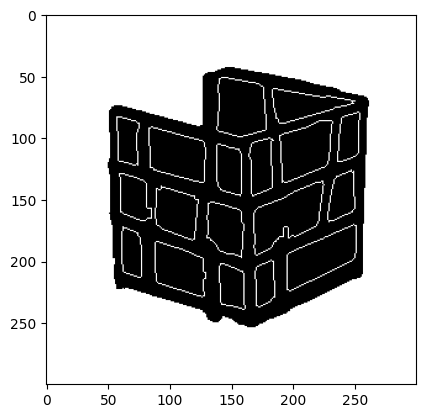

In [8242]:
# facciamo un fill per rimuovere noise nel background, partendo dalla cornice nera creata precedentemente
# proprio grazia alla cornice, partendo da un solo punto, possiamo rimepire da tutto il bordo!

cv2.floodFill(edge_image, None, (0, 0), 255)

plt.imshow(edge_image,cmap="gray")

area:34987.0
perimeter of detected cube: 805.78888463974


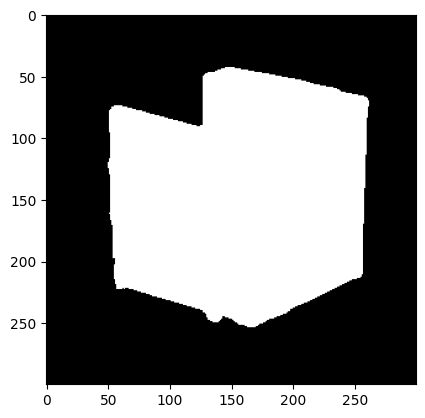

In [8243]:
contours, _ = cv2.findContours(cv2.bitwise_not(edge_image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_contour=contours[0]
max_area=cv2.contourArea(max_contour)

for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if(max_area<area):
        max_contour=c
        max_area=area
    print("area:"+str(area))

# Determine which area is larger and create a mask
single_thresh = np.zeros_like(edge_image)
cv2.drawContours(single_thresh, [max_contour], -1, (255,255,255), -1)
perimeter = cv2.arcLength(max_contour, True)
print("perimeter of detected cube: "+str(perimeter))

# Apply the mask
plt.imshow(single_thresh,cmap="gray")

In [8244]:
# espandiamo il colore bianco, per cercare di riempire i buchi, non solo all'interno ma anche sul bordo
erosion = single_thresh
#kernel = np.ones((3,3),np.uint8)
#erosion = cv2.erode(single_thresh,kernel,iterations = 1)
#plt.imshow(erosion,cmap="gray")

(300, 300, 3)
(300, 300)


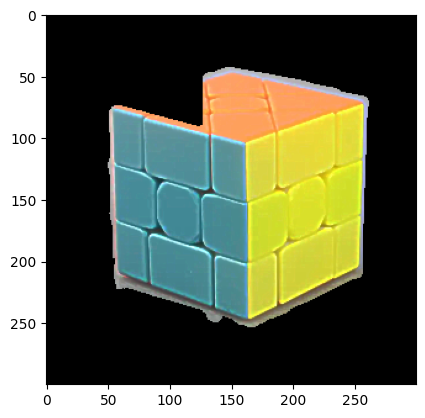

In [8245]:
# appliyng the ROI to the input image

print(input_image.shape)
print(erosion.shape)

ROI = cv2.bitwise_and(high_pass_input_image, high_pass_input_image, mask=erosion)
plt.imshow(cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB))

Minimal Vertex Distance: 11.511269780567714


C:\Users\Ceron\AppData\Local\Temp\ipykernel_27232\3227055779.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  raw_corners = np.int0(raw_corners)


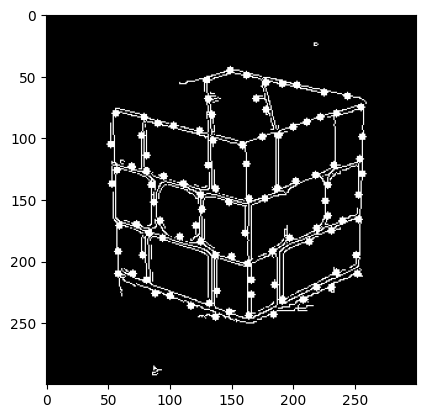

In [8246]:
minimal_vertex_distance = perimeter/70
print("Minimal Vertex Distance: "+str(minimal_vertex_distance))
img = cv2.imread('blox.jpg')
raw_corners = cv2.goodFeaturesToTrack(iedges,maxCorners=0,qualityLevel=0.001,minDistance=minimal_vertex_distance,mask=erosion)
raw_corners = np.int0(raw_corners)
corners = [(0,0) for x in range(len(raw_corners))]

for i in range(len(raw_corners)):
    x,y = raw_corners[i].ravel()
    cv2.circle(iedges,(x,y),3,255,-1)
    corners[i] = (x,y)

plt.imshow(cv2.cvtColor(iedges, cv2.COLOR_BGR2RGB))

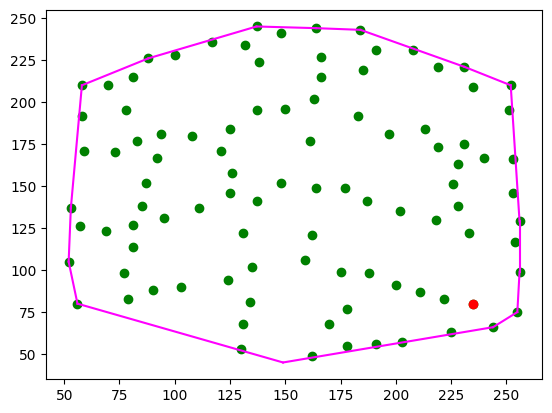

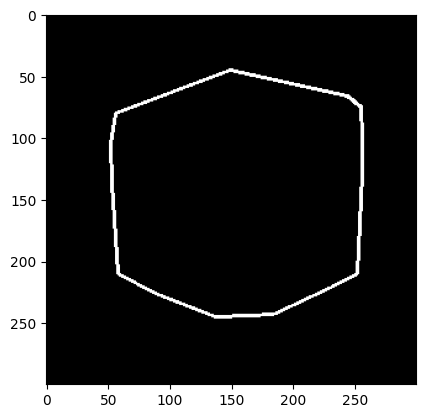

In [8247]:
# get the convex hull, to ignore all the gaps present on the border of the image
points_wrap = graham_scan(corners)

xs, ys = zip(*corners)  # unzip into x and y coord lists
plt.scatter(xs, ys, c='green')  # plot the data points
plt.scatter(corners[0][0], corners[0][1], c='red')  # left bottom point

for i in range(1, len(points_wrap)+1):
    if i == len(points_wrap):
        i = 0  # close the figure (paths)
    c0 = points_wrap[i-1]
    c1 = points_wrap[i]
    # build/draw segment [c0; c1]
    plt.plot((c0[0], c1[0]), (c0[1], c1[1]), 'magenta')
plt.show()

void = np.zeros_like(erosion)
hull = np.array(points_wrap, dtype=np.int32).reshape((-1, 1, 2))
void = cv2.drawContours(void, [hull], -1, 255, 2)

plt.imshow(void,cmap="gray")

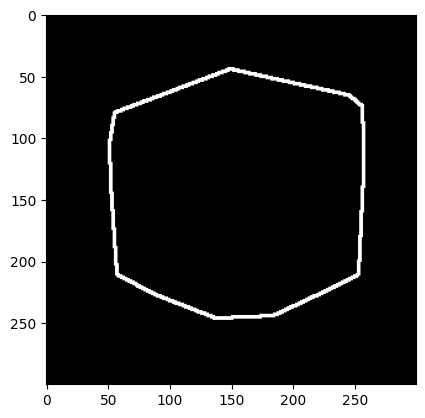

In [8248]:
contours, _ = cv2.findContours(void, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_contour=contours[0]


# Determine which area is larger and create a mask
single_thresh = np.zeros_like(void)
cv2.drawContours(single_thresh, [max_contour], -1, 255, 2)

# Apply the mask
plt.imshow(single_thresh,cmap="gray")

In [8249]:
lines = cv2.HoughLines(single_thresh, 1, np.pi / 360, int(perimeter/15), None, 0, 0)
print(len(lines))

120


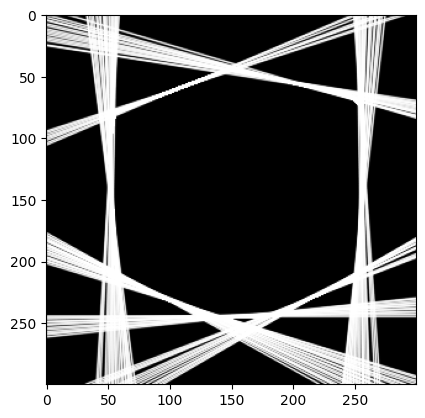

In [8250]:
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(single_thresh, pt1, pt2, 255, 1, cv2.LINE_AA)
plt.imshow(single_thresh,cmap="gray")

C:\Users\Ceron\AppData\Local\Temp\ipykernel_27232\4203726660.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x0), float(y0)  # Make sure the return values are floats


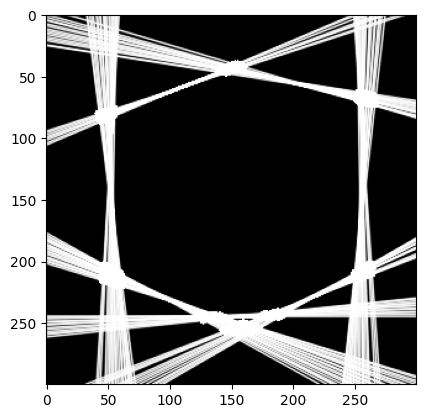

In [8251]:
angular_threshold = 20
#  get the intersection that only happen near the border of the cube
intersections = find_intersections(lines, hull, angular_threshold)

for i in intersections:
    cv2.circle(single_thresh,i,3,255,-1)

plt.imshow(cv2.cvtColor(single_thresh, cv2.COLOR_BGR2RGB))

In [8252]:
epsilon = 50  # Define the radius parameter epsilon which is the maximum distance between two samples for one to be considered as in the neighborhood of the other.
min_samples = 5  # Define the minimum number of points required to form a cluster
intersections = np.array(intersections)

db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(intersections)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = [intersections[labels == i] for i in range(n_clusters)]

# Calculate mean for each cluster
corners = [np.mean(cluster, axis=0) for cluster in clusters]

print(len(corners))
for i in range(len(corners)):
    corners[i] = corners[i].astype(int)

6


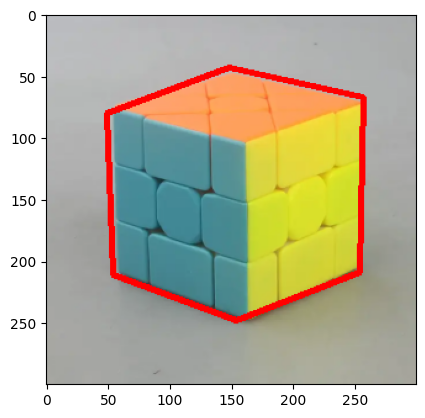

In [8253]:
sorted_vertices = sorted(corners, key=lambda point: (point[1]))
highest_vertex = tuple(sorted_vertices[0])
lowest_vertex = tuple(sorted_vertices[-1])

impression = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)

upper_right=lower_right=upper_left=lower_left=0
upper_right_angle=upper_left_angle=0
if(sorted_vertices[1][0] > sorted_vertices[2][0]):
    upper_right = tuple(sorted_vertices[1])
    upper_left = tuple(sorted_vertices[2])
else:
    upper_right = tuple(sorted_vertices[2])
    upper_left = tuple(sorted_vertices[1])
if(sorted_vertices[3][0] > sorted_vertices[4][0]):
    lower_right = tuple(sorted_vertices[3])
    lower_left = tuple(sorted_vertices[4])
else:
    lower_right = tuple(sorted_vertices[4])
    lower_left = tuple(sorted_vertices[3])

cv2.line(impression, upper_right, lower_right, (0, 0, 255), thickness = 3)
cv2.line(impression, upper_left, lower_left, (0, 0, 255), thickness = 3)
cv2.line(impression, lower_left, lowest_vertex, (0, 0, 255), thickness = 3)
cv2.line(impression, lower_right, lowest_vertex, (0, 0, 255), thickness = 3)
cv2.line(impression, upper_right, highest_vertex, (0, 0, 255), thickness = 3)
cv2.line(impression, upper_left, highest_vertex, (0, 0, 255), thickness = 3)

plt.imshow(cv2.cvtColor(impression, cv2.COLOR_BGR2RGB))

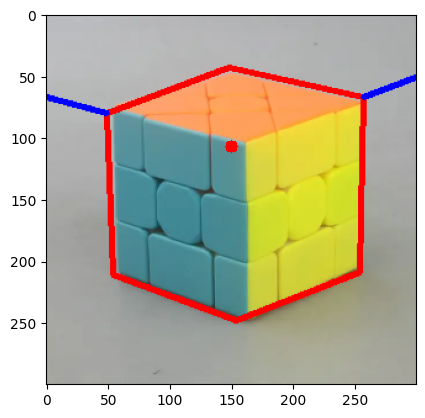

In [8254]:
intersection1 = line_intersection(lower_left,lowest_vertex,highest_vertex,upper_right)
intersection2 = line_intersection(lower_right,lowest_vertex,highest_vertex,upper_left)
center = line_intersection(intersection1,upper_left,intersection2,upper_right)
center = (int(center[0]),int(center[1]))

cv2.line(impression, (int(intersection1[0]),int(intersection1[1])), upper_left, (255, 0, 0), thickness = 3)
cv2.line(impression, (int(intersection2[0]),int(intersection2[1])), upper_right, (255, 0, 0), thickness = 3)
cv2.circle(impression, center, 5, (0,0,255), thickness=cv2.FILLED)
plt.imshow(cv2.cvtColor(impression, cv2.COLOR_BGR2RGB))

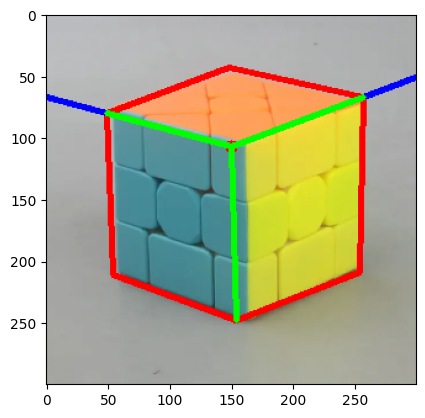

In [8255]:
cv2.line(impression, lowest_vertex, center, (0, 255, 0), thickness = 3)
cv2.line(impression, upper_left, center, (0, 255, 0), thickness = 3)
cv2.line(impression, upper_right, center, (0, 255, 0), thickness = 3)

plt.imshow(cv2.cvtColor(impression, cv2.COLOR_BGR2RGB))

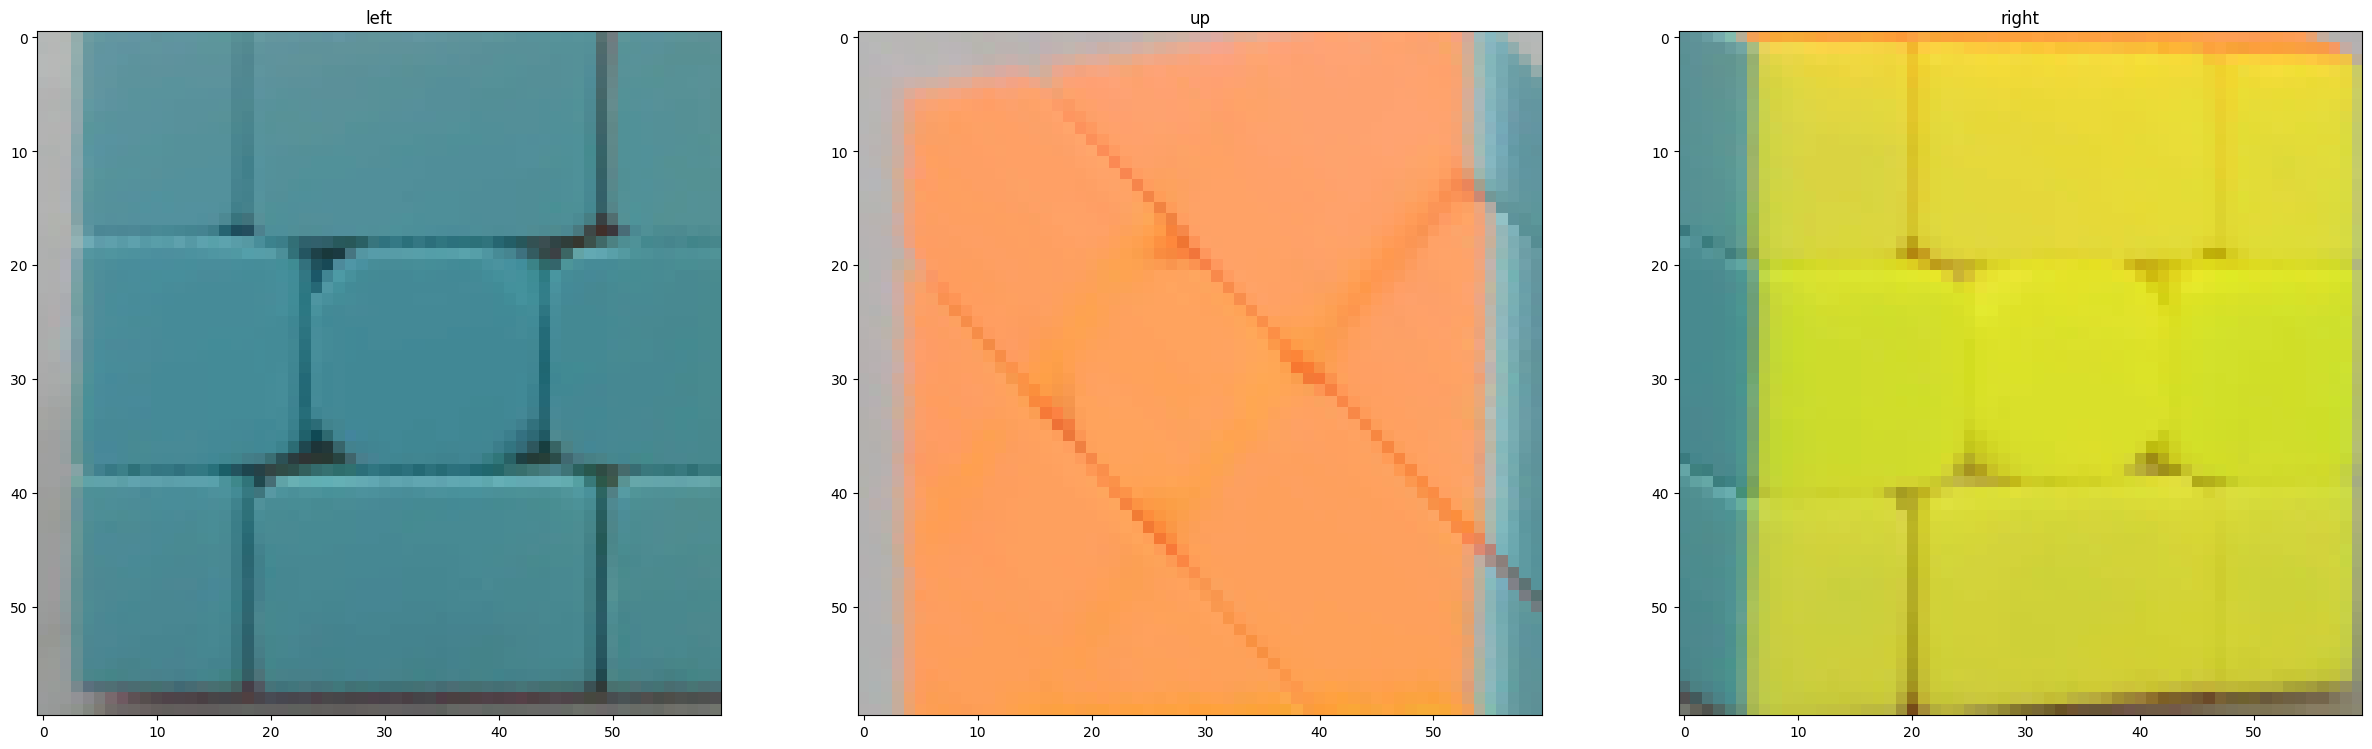

In [8256]:
dst_square_size = 60
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
dst_coordinates = np.array([[0, 0], [dst_square_size - 1, 0], [dst_square_size - 1, dst_square_size - 1], [0, dst_square_size - 1]], dtype=np.float32)

coordinates = np.array([highest_vertex, upper_left, center, upper_right], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image1 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ center, upper_right, lower_right, lowest_vertex], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image2 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ upper_left, center, lowest_vertex, lower_left], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image3 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

imshow_all(cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB),titles=["left","up","right"])

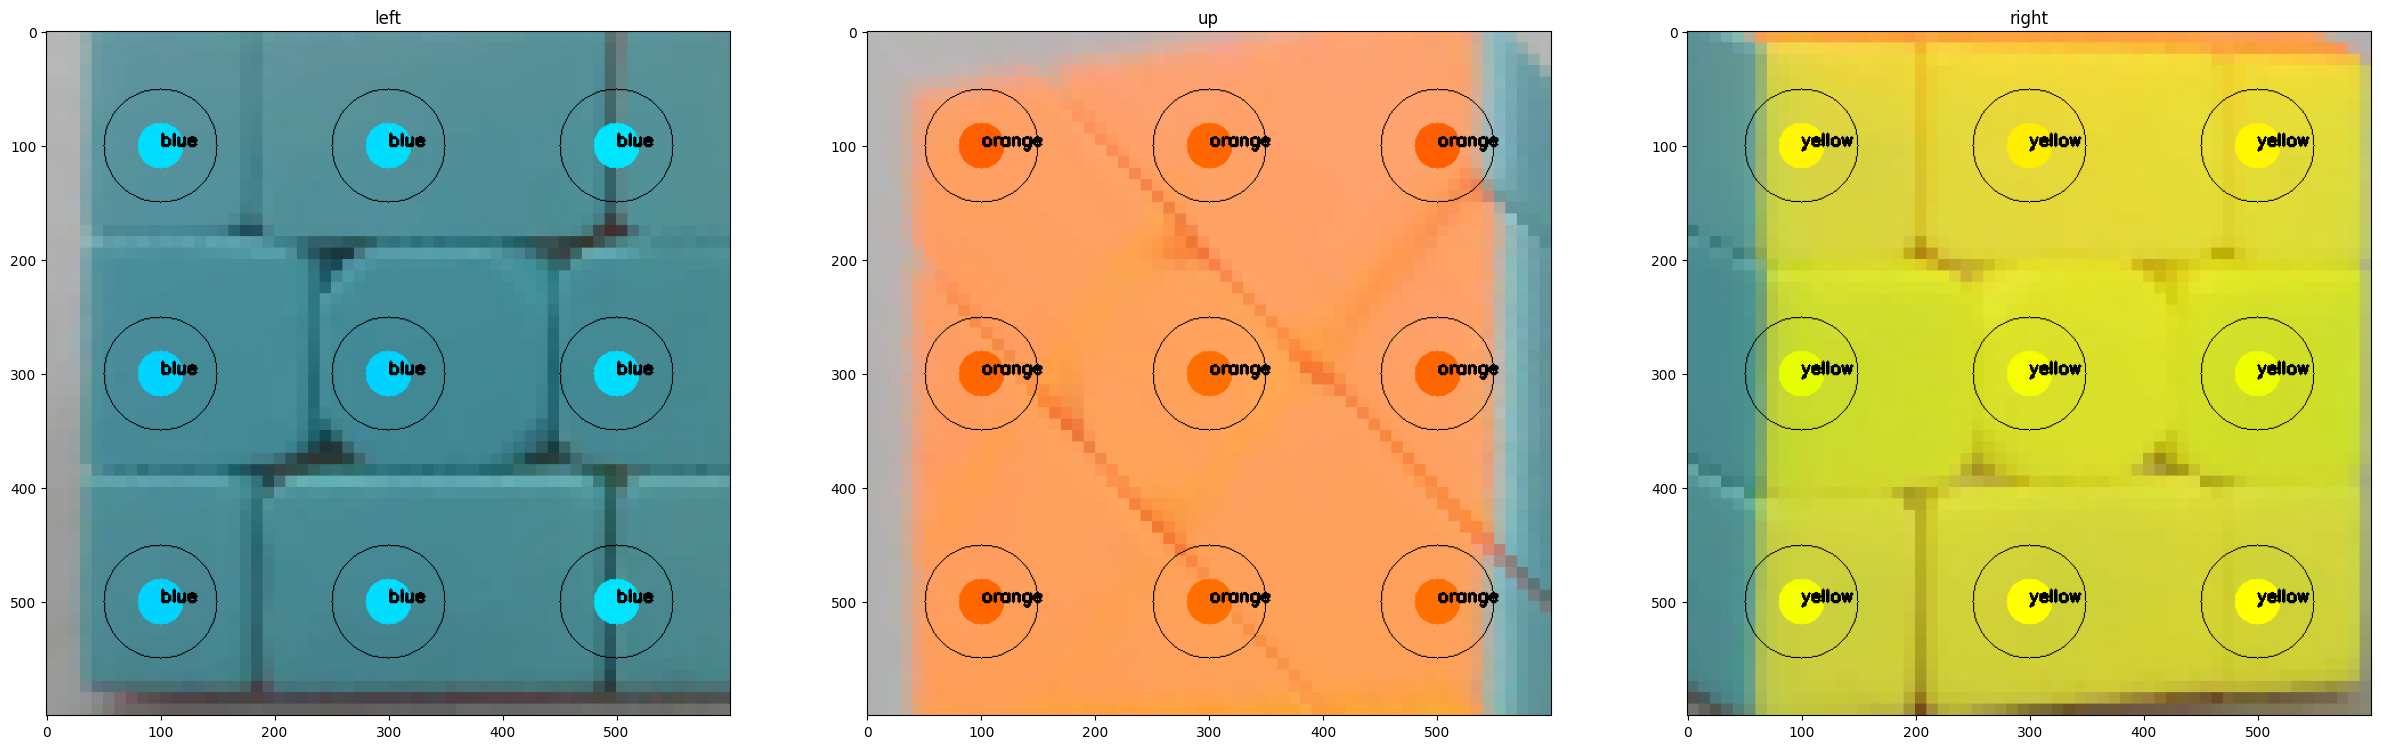

In [8257]:
tmp1 = cv2.resize(result_image1, (600, 600), interpolation = cv2.INTER_AREA)
tmp2 = cv2.resize(result_image2, (600, 600), interpolation = cv2.INTER_AREA)
tmp3 = cv2.resize(result_image3, (600, 600), interpolation = cv2.INTER_AREA)

h, s, v = cv2.split(cv2.cvtColor(result_image1, cv2.COLOR_BGR2HSV))
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
hsv_image1 = cv2.merge([h, s, v])

h, s, v = cv2.split(cv2.cvtColor(result_image2, cv2.COLOR_BGR2HSV))
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
hsv_image2 = cv2.merge([h, s, v])

h, s, v = cv2.split(cv2.cvtColor(result_image3, cv2.COLOR_BGR2HSV))
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
hsv_image3 = cv2.merge([h, s, v])

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):

        hue_average_color = most_common_hue(hsv_image1, (i,j), 5)
        color_name, bgr_color = hue_to_color_name_and_bgr(hue_average_color)
        color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2])) 
        
        cv2.circle(tmp1, (j*10, i*10), 50, (0, 0, 0), 1)
        cv2.circle(tmp1, (i*10, j*10), 20, color, thickness=cv2.FILLED)
        cv2.putText(tmp1, color_name, (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        hue_average_color = most_common_hue(hsv_image2, (i,j), 5)
        color_name, bgr_color = hue_to_color_name_and_bgr(hue_average_color)
        color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2]))

        cv2.circle(tmp2, (j*10, i*10), 50, (0, 0, 0), 1)
        cv2.circle(tmp2, (i*10, j*10), 20, color, thickness=cv2.FILLED)
        cv2.putText(tmp2, color_name, (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        hue_average_color = most_common_hue(hsv_image3, (i,j), 5)
        color_name, bgr_color = hue_to_color_name_and_bgr(hue_average_color)
        color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2]))
        
        cv2.circle(tmp3, (j*10, i*10), 50, (0, 0, 0), 1)
        cv2.circle(tmp3, (i*10, j*10), 20, color, thickness=cv2.FILLED)
        cv2.putText(tmp3, color_name, (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

imshow_all(cv2.cvtColor(tmp3, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB),titles=["left","up","right"])